In [5]:
import numpy as np
import os.path as osp
import pandas as pd
import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load MusicRecords data from a CSV file
df = pd.read_csv("MusicData.csv", encoding='ISO-8859-1')

# Display the data types of each column
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7574 entries, 0 to 7573
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      7574 non-null   int64  
 1   songtitle                 7574 non-null   object 
 2   artistname                7574 non-null   object 
 3   songID                    7574 non-null   object 
 4   artistID                  7574 non-null   object 
 5   timesignature             7574 non-null   int64  
 6   timesignature_confidence  7574 non-null   float64
 7   loudness                  7574 non-null   float64
 8   tempo                     7574 non-null   float64
 9   tempo_confidence          7574 non-null   float64
 10  key                       7574 non-null   int64  
 11  key_confidence            7574 non-null   float64
 12  energy                    7574 non-null   float64
 13  pitch                     7574 non-null   float64
 14  timbre_0

In [6]:
# Data Exploration
#1. any duplicate songs? - No Duplicate songs

# Identify distinct songs by title and artist
distinct_songs = df[['songtitle', 'artistname']].drop_duplicates()

num_distinct_songs = distinct_songs.shape[0]
print(f"Number of original records: {df.shape}")
print(f"Number of distinct songs: {num_distinct_songs}")

Number of original records: (7574, 39)
Number of distinct songs: 7574


In [7]:
#2. Identifying Outliers
# Define a function to identify outliers using the IQR method
def identify_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Identify outliers for specific columns (e.g., 'loudness', 'tempo', 'pitch')
outliers_loudness = identify_outliers_iqr(df, 'loudness')
outliers_tempo = identify_outliers_iqr(df, 'tempo')
outliers_pitch = identify_outliers_iqr(df, 'pitch')

# Display the outliers
print("Outliers in Loudness:")
print(outliers_loudness)

print("Outliers in Tempo:")
print(outliers_tempo)

print("Outliers in Pitch:")
print(outliers_pitch)

Outliers in Loudness:
      year                              songtitle    artistname  \
54    2010                         Find Your Love         Drake   
66    2010                   After the Earthquake          Eels   
68    2010  In Gratitude for This Magnificent Day          Eels   
69    2010                            The Morning          Eels   
284   2010                               Meridian    Shearwater   
...    ...                                    ...           ...   
7440  1990                         Downtown Train   Rod Stewart   
7488  1990                        Pump Up The Jam  Technotronic   
7508  1990                        Grapes of Wrath   The Mission   
7531  1990                               Jerk Out      The Time   
7553  1990                       Over Rusty Water           XTC   

                  songID            artistID  timesignature  \
54    SOJSITU13A9DF07483  ARODZUF11F4C841E1F              4   
66    SOAFCZJ1315CD3F8A2  ARZGTK71187B9AC7F5   

In [8]:
# Define a function to identify outliers using the Standard Deviation method
def identify_outliers_std(df, column, threshold=3):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Identify outliers for specific columns (e.g., 'loudness', 'tempo', 'pitch')
outliers_loudness_std = identify_outliers_std(df, 'loudness')
outliers_tempo_std = identify_outliers_std(df, 'tempo')
outliers_pitch_std = identify_outliers_std(df, 'pitch')

# Display the outliers
print("Outliers in Loudness (using Std Dev):")
print(outliers_loudness_std)

print("Outliers in Tempo (using Std Dev):")
print(outliers_tempo_std)

print("Outliers in Pitch (using Std Dev):")
print(outliers_pitch_std)

Outliers in Loudness (using Std Dev):
      year               songtitle       artistname              songID  \
291   2010         Missing Islands       Shearwater  SOXLNOD12AB0186599   
602   2009       Hello (Interlude)  Newton Faulkner  SOHHUHJ12AB0189148   
612   2009  Cheltenham (Interlude)  Newton Faulkner  SOYTNXU12AB018916F   
769   2009                Preamble  Umphrey's McGee  SOGLBMU12AAFF44402   
775   2009                Red Tape  Umphrey's McGee  SOBQXLK1392680128C   
...    ...                     ...              ...                 ...   
7083  1991         Sadeness Part 1           Enigma  SONQDDJ12A8C13AA67   
7217  1991                   Dylan   Throwing Muses  SOIKLRU1315CD41009   
7395  1990                     Woe     Mark Lanegan  SOATKDR12A8C13460C   
7531  1990                Jerk Out         The Time  SOZMVEU12B3A15A389   
7553  1990        Over Rusty Water              XTC  SOMBCEG12A6BD5677B   

                artistID  timesignature  timesignature_confid

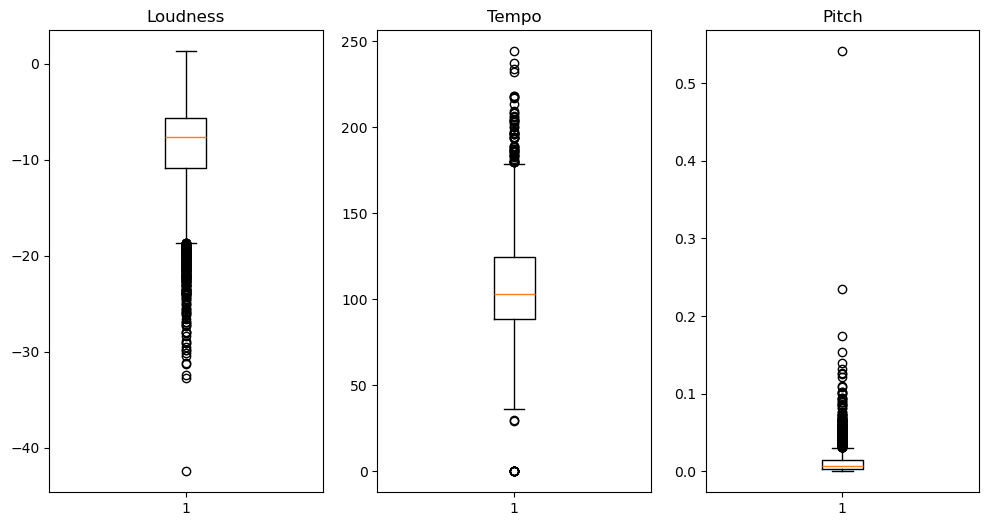

In [9]:
import matplotlib.pyplot as plt

# Plotting box plots to visualize outliers
plt.figure(figsize=(12, 6))

# Loudness Boxplot
plt.subplot(1, 3, 1)
plt.boxplot(df['loudness'])
plt.title('Loudness')

# Tempo Boxplot
plt.subplot(1, 3, 2)
plt.boxplot(df['tempo'])
plt.title('Tempo')

# Pitch Boxplot
plt.subplot(1, 3, 3)
plt.boxplot(df['pitch'])
plt.title('Pitch')

plt.show()

In [10]:
# Data Cleaning
# 1. Turning the song title and and artist name into numerical fields using label encoder, we are able to drop song title/song ID an artist name/artistID since we have converted the columns into numerical values.
# The reason why we want to include this information in our initial data since this kind of information may bring in some insights that we may not know

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

df['songtitle_encoded'] = label_encoder.fit_transform(df['songtitle'])
df['artistname_encoded'] = label_encoder.fit_transform(df['artistname'])

df = df.drop(columns = ['songtitle', 'artistname','songID','artistID'])

# 2. Removing Outliers from the data loudness Tempo and Pitch as we could see from the boxplot, standard deviation and IQR method there are outliers in the data.
# Outliers may affect our model results/accuracy and it is important to remove 

df = df[~df.index.isin(outliers_loudness.index)]
df = df[~df.index.isin(outliers_tempo.index)]
df = df[~df.index.isin(outliers_pitch.index)]

# Check the cleaned data
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6809 entries, 0 to 7573
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      6809 non-null   int64  
 1   timesignature             6809 non-null   int64  
 2   timesignature_confidence  6809 non-null   float64
 3   loudness                  6809 non-null   float64
 4   tempo                     6809 non-null   float64
 5   tempo_confidence          6809 non-null   float64
 6   key                       6809 non-null   int64  
 7   key_confidence            6809 non-null   float64
 8   energy                    6809 non-null   float64
 9   pitch                     6809 non-null   float64
 10  timbre_0_min              6809 non-null   float64
 11  timbre_0_max              6809 non-null   float64
 12  timbre_1_min              6809 non-null   float64
 13  timbre_1_max              6809 non-null   float64
 14  timbre_2_min 

In [11]:
# model building

# Splitting data into training and testing sets
train_df = df[df['year'] <= 2009]
test_df = df[df['year'] == 2010]

# Building a logistic regression model to predict Top10 using the training data.
X_train = train_df.drop(columns="Top10")
y_train = train_df["Top10"]

# Adding a constant column for the intercept
X_train_sm = sm.add_constant(X_train)

# Building the logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Displaying the summary
result.summary()

Optimization terminated successfully.
         Current function value: 0.336470
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Top10   No. Observations:                 6462
Model:                          Logit   Df Residuals:                     6425
Method:                           MLE   Df Model:                           36
Date:                Sat, 24 Aug 2024   Pseudo R-squ.:                  0.2089
Time:                        14:40:19   Log-Likelihood:                -2174.3
converged:                       True   LL-Null:                       -2748.3
Covariance Type:            nonrobust   LLR p-value:                1.146e-217
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      148.2736     15.534      9.545      0.000     117.827     178.721
year                        -0.0664      0.008     -8.680      0.000      -0.081      -0.051
timesignature                0.0967      0.096      1.007      0.314      -0.092       0.285
timesignature_confidence     0.6498      0.211      3.079      0.002       0.236       1.063
loudness                     0.3186      0.032      9.947      0.000       0.256       0.381
tempo                        0.0025      0.002      1.341      0.180      -0.001       0.006
tempo_confidence             0.4122      0.149      2.758      0.006       0.119       0.705
key                          0.0097      0.011      0.891      0.373      -0.012       0.031
key_confidence               0.2540      0.148      1.719      0.086      -0.036       0.544
energy                      -1.6244      0.323     -5.025      0.000      -2.258      -0.991
pitch                      -61.2050      8.557     -7.153      0.000     -77.977     -44.433
timbre_0_min                 0.0296      0.004      6.608      0.000       0.021       0.038
timbre_0_max                -0.3305      0.028    -11.896      0.000      -0.385      -0.276
timbre_1_min                 0.0056      0.001      6.887      0.000       0.004       0.007
timbre_1_max                -0.0004      0.001     -0.586      0.558      -0.002       0.001
timbre_2_min                -0.0007      0.001     -0.553      0.580      -0.003       0.002
timbre_2_max                 0.0011      0.001      1.145      0.252      -0.001       0.003
timbre_3_min                 0.0009      0.001      1.456      0.145      -0.000       0.002
timbre_3_max                -0.0025      0.001     -4.110      0.000      -0.004      -0.001
timbre_4_min                 0.0122      0.002      5.746      0.000       0.008       0.016
timbre_4_max                 0.0065      0.002      3.982      0.000       0.003       0.010
timbre_5_min                -0.0053      0.001     -3.952      0.000      -0.008      -0.003
timbre_5_max                -0.0001      0.001     -0.136      0.892      -0.002       0.002
timbre_6_min                -0.0158      0.002     -6.643      0.000      -0.021      -0.011
timbre_6_max                 0.0033      0.002      1.434      0.152      -0.001       0.008
timbre_7_min                -0.0068      0.002     -3.658      0.000      -0.010      -0.003
timbre_7_max                -0.0020      0.002     -1.048      0.295      -0.006       0.002
timbre_8_min                 0.0040      0.003      1.353      0.176      -0.002       0.010
timbre_8_max                 0.0023      0.003      0.714      0.475      -0.004       0.009
timbre_9_min                 0.0010      0.003      0.321      0.748      -0.005       0.007
timbre_9_max                 0.0018      0.003      0.716      0.474      -0.003       0.007
timbre_10_min                0.0030      0.002      1.561      0.119      -0.00

In [14]:
# Making predictions on the test set
X_test = test_df.drop(columns="Top10")
y_test = test_df["Top10"]
log_reg = LogisticRegression(max_iter=10000)

# Fit the model using sklearn
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]   # Probabilities of being in the "Top10" category

predicted_classes = (y_pred_prob > 0.15).astype(int)  # Convert probabilities to class predictions based on a threshold of 0.15

# Creating a confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Computing the accuracy rate on the test set
test_accuracy = (predicted_classes == y_test).mean()

print("Confusion Matrix:")
print(conf_matrix)
print(f"Test Accuracy: {test_accuracy:.4f}")


Confusion Matrix:
[[204  86]
 [ 13  44]]
Test Accuracy: 0.7147


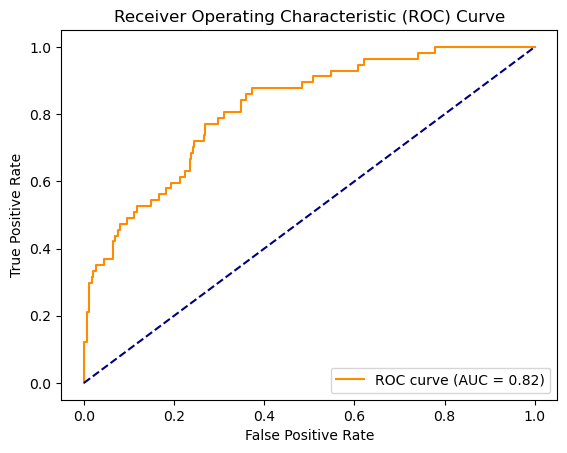

In [15]:
# Generating the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Question 1 [15 pts]: Fit a logistic regression model using all variable

A logistic regression model is used to predict whether a song would reach top 10 on the BillBoard Hot 100 Chart. This analysis was done by using all musical features in the data provided. This model was able to achieve an accuracy of 71.47% and an AUC of 0.82, meaning that it was able to tell the difference between popular and un-popular songs. 

Steps taken for the analysis:
1. Importing the music dataset - 7573 records and 39 fields
2. Checking the data for any missing values, missing values can cause a bias in the model and could potentially reduce the accuracy and effective of the model- No null values were found
3. Checking the data for outliers, Models, like linear and logistic regression, optimize for minimizing error, they might get pulled towards these outlier points, which can lead to reducing the accuracy of the model. In this analysis we used the IQR method to remove outliers. After reviewing the loudness, tempo and pitch features, there are outliers in the dataset and are removed for the the model.
4. Conversion of object variables to numerical. Models are only able to use numerical variables, since song and artists are objects, they will need to be converted to numerical using label encoder. With this converted to numerical, we will be able to use all variables for the model
5. Splitting the data into train and test - anything before 2009 will be our train data and songs in 2010 will be used to predict whether or not a song will make top 10.
6. Performing a logistic Regression - Year, timesignature_confidence, loudness, tempo_confidence, energy, pitch, timbre and artist name all have a p value < 0.05 meaning they are significant to the model
7. Performing a Confusion Matrix - This showed an accuracy of 71.47%
    True Negatives = 204 of making it top 10
    False Positives = 86 of making it top 10
    False Negative = 13 of making it top 10
    True Positives = 44 of making it top 10
    86 cases where it was classified as making it top 10 - Type 1 Error
    13 Cases where it was classified as not making it top 10 when it should have - Type 2 Error

8. Performing an ROC Curve, provides insights into how well the model distinguishes between the positive and negative classes, independent of the decision threshold.
    •	AUC = 0.5: No discriminative power (same as random guessing).
	•	AUC < 0.5: Worse than random guessing (rare in practice).
	•	AUC > 0.5: The model has some discriminatory power. Higher AUC values indicate better model performance.

    AUC = 0.82 chance that the model will rank a randomly chosen positive instance (Top 10 song) higher than a randomly chosen negative instance (not Top 10 song). This is a good indication that your model has high discriminatory power, effectively distinguishing between hits and non-hits.

These findings provide valuable insights for music producers and marketers to optimize their strategies for promoting potential hit songs.




In [17]:
X_test = test_df.drop(columns=['Top10'])  # Features for testing
y_test = test_df['Top10']  # True labels for testing

# Predict probabilities of being in the "Top10" category
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]  # Probability of being in the Top 10

# Set a threshold to decide class labels; e.g., use 0.5 as a typical threshold
predicted_classes = (y_pred_prob > 0.5).astype(int)  # Using a threshold of 0.5 for binary classification

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Accuracy
test_accuracy = accuracy_score(y_test, predicted_classes)
print(f"Accuracy: {test_accuracy:.4f}")

# Precision
precision = precision_score(y_test, predicted_classes)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, predicted_classes)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, predicted_classes)
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[288   2]
 [ 49   8]]
Accuracy: 0.8530
Precision: 0.8000
Recall: 0.1404
F1 Score: 0.2388


### Question 2 [15 pts]: Predict the popularity of records in the testing set.

Confusion Matrix
    True Negatives = 288 of making it top 10
    False Positives = 2 of making it top 10
    False Negative = 49 of making it top 10
    True Positives = 8 of making it top 10

    2 cases where it was classified as making it top 10 - Type 1 Error
    49 Cases where it was classified as not making it top 10 when it should have - Type 2 Error
    

In [13]:
# # Splitting data into training and testing sets
# train_df = df[df['year'] <= 2009]
# test_df = df[df['year'] == 2010]

# # we want to exclude some of the variables in our dataset from being used as independent variables
# # ("year", "songtitle", "artistname", "songID", and "artistID").
# columns_to_exclude = ["year", "songtitle", "artistname", "songID", "artistID"]

# # To remove these variables from training and testing sets:
# train_df = train_df.drop(columns=columns_to_exclude)
# test_df = test_df.drop(columns=columns_to_exclude)

# # Building a logistic regression model to predict Top10 using the training data.
# X_train = train_df.drop(columns="Top10")
# y_train = train_df["Top10"]

# # Adding a constant column for the intercept
# X_train_sm = sm.add_constant(X_train)

# # Building the logistic regression model using statsmodels
# logit_model = sm.Logit(y_train, X_train_sm)
# result = logit_model.fit()

# # Displaying the summary
# result.summary()

True or False?
1. The higher our confidence about time signature, key and tempo, the more likely the song is to be in the Top 10
2. In general, if the confidence is low for the time signature, tempo, and key, then the song is more likely to be complex. What does our model suggest in terms of complexity?

In [ ]:
# # Making predictions on the test set
# X_test = test_df.drop(columns="Top10")
# y_test = test_df["Top10"]

# y_pred_prob = log_reg.predict_proba(X_test)[:, 1]   # Probabilities of being in the "Top10" category

# predicted_classes = (y_pred_prob > 0.15).astype(int)  # Convert these probabilities into class predictions (i.e., 1 for "Top10" and 0 otherwise) based on a threshold 0.15.

# # Creating a confusion matrix
# conf_matrix = confusion_matrix(y_test, predicted_classes)

# # Computing the accuracy rate on the test set
# test_accuracy = (predicted_classes == y_test).mean()

# print(conf_matrix)
# print(test_accuracy)

NameError: name 'test_df' is not defined

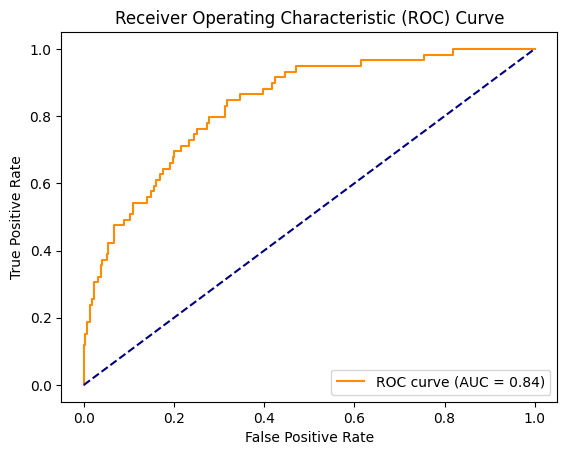

In [ ]:
# # Generating the ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# roc_auc = auc(fpr, tpr)

# # Plotting the ROC curve
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

In [17]:
# import pandas as pd
# import statsmodels.api as sm

# # Assuming df is already loaded
# # Splitting data into training and testing sets
# train_df = df[df['year'] <= 2009]
# test_df = df[df['year'] == 2010]

# # Defining columns to exclude
# columns_to_exclude = ["year", "songtitle", "artistname", "songID", "artistID"]

# # Removing these variables from training and testing sets
# train_df = train_df.drop(columns=columns_to_exclude)
# test_df = test_df.drop(columns=columns_to_exclude)

# # Building a logistic regression model to predict Top10 using the training data
# X_train = train_df.drop(columns="Top10")
# y_train = train_df["Top10"]

# # Adding a constant column for the intercept
# X_train_sm = sm.add_constant(X_train)

# # Building the logistic regression model using statsmodels
# logit_model = sm.Logit(y_train, X_train_sm)
# result = logit_model.fit()

# # Displaying the summary
# print(result.summary())

Optimization terminated successfully.
         Current function value: 0.330451
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Top10   No. Observations:                 7201
Model:                          Logit   Df Residuals:                     7167
Method:                           MLE   Df Model:                           33
Date:                Sat, 17 Aug 2024   Pseudo R-squ.:                  0.2091
Time:                        14:35:11   Log-Likelihood:                -2379.6
converged:                       True   LL-Null:                       -3008.8
Covariance Type:            nonrobust   LLR p-value:                2.683e-243
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       14.7000      1.806      8.138      0.000      11.160